# Stanford dogs: breed classifier

## 1. Import libraries and define data folders

In [1]:
# files loading
import os

from random import shuffle
import numpy as np
!pip install tqdm
from tqdm import tqdm # progress bar

In [2]:
# image pretreatment
import matplotlib.pyplot as plt

import cv2
import numpy as np

from PIL import Image

In [3]:
#horizontal flip image augmentation libraries

import keras
from numpy import expand_dims
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

In [4]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
# 

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


In [6]:
# libraries for a CNN
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Activation
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical



from tensorflow.python.client import device_lib


In [7]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#for gpu in gpus:
#    tf.config.experimental.set_memory_growth(gpu, True)


In [8]:
#print(device_lib.list_local_devices())
#print(tf.config.list_physical_devices('GPU'))
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# confirm TensorFlow sees the GPU
#from tensorflow.python.client import device_lib
#assert 'GPU' in str(device_lib.list_local_devices())

In [9]:
tf.__version__

'2.2.0'

In [10]:
#tf.test.is_built_with_cuda()

In [11]:
#tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

In [12]:
ANNOTATION_DIR = '/media/marco/DATA/OC_Machine_learning/section_6/DATA/Annotation/' 
IMAGES_DIR = '/media/marco/DATA/OC_Machine_learning/section_6/DATA/Images/'

### 1.1 Visualize list of breeds (classes) and a sample data (image)

In [13]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 120


In [14]:
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] #visualize breeds
filtered_breeds[:7]

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon']

## 1.2 Example equalization 

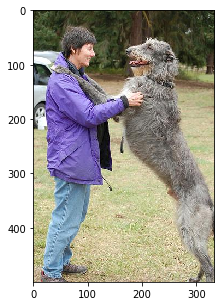

In [15]:
## set the seed for the np.random module, so we always get the same image when run this code cell
np.random.seed(11)

# since we just want one image, I'll ramdomly choose a breed and a dog from that breed
breed = np.random.choice(breed_list)
dog = np.random.choice(os.listdir(ANNOTATION_DIR + breed))

# opening one image
img = cv2.imread(IMAGES_DIR + breed + '/' + dog + '.jpg') 
# this line is necessary because cv2 reads an image in BGR format (Blue, Green, Red) by default. 
# So we will convert it to RGB
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
plt.figure(figsize = (5,5))
plt.imshow(img_RGB)

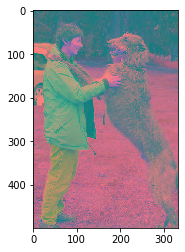

In [16]:
plt.imshow(img_to_yuv)

image above shows that we have humans together with dogs

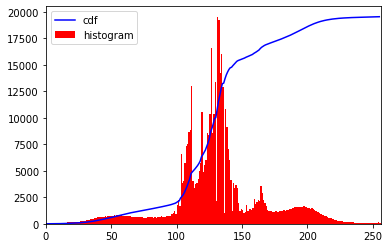

In [17]:
hist,bins = np.histogram(img_to_yuv.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_to_yuv.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

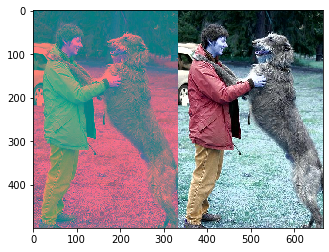

In [18]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_to_yuv,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

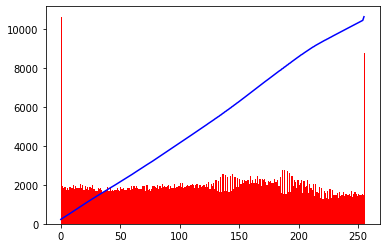

In [19]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.show()

## 1.3 Example augmentations: mirroring and rotation

Augmented by mirroring:


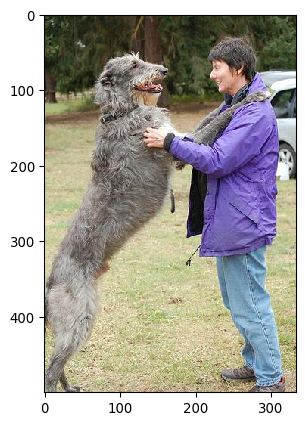

In [20]:
ia.seed(4)

rotate = iaa.Affine(rotate=(-60, 60))
image_aug_1 = rotate(image=img_RGB)
mirror = iaa.Fliplr(0.5)
image_aug_2 = mirror(image=img_RGB)
print("Augmented by mirroring:")
ia.imshow(image_aug_2)

Augmented by rotation:


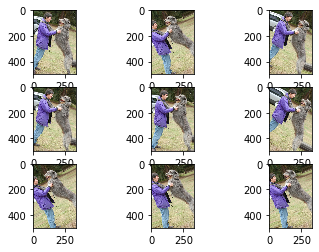

<Figure size 720x720 with 0 Axes>

In [21]:
print("Augmented by rotation:")
#ia.imshow(image_aug_2)
# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (10,10))
plt.show()

## 1.4 Batch processing - equalization and augmentation

In [22]:
num_breeds = 7 # integer between 2 and 120
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) # convert to yuv color space for equalization
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) # equalize
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(filtered_breeds[index])
            
    return img_lst, labels 

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))

No. of images loaded =  1336 
No. of labels loaded =  1336


In [23]:
labels[:2]

['Chihuahua', 'Chihuahua']

In [24]:
le = LabelEncoder()
images = np.array(images)
nlabels = le.fit_transform(labels)
nlabels = np.array(nlabels)

## 2. Prepare data for training the CNN model

- For training the CNN model we have to shuffle all the data that is loaded in images, labels list.

### 2.1 data shuffling

In [25]:
#step 1 - get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("10 'n' values before shuffling = ",n[:10])

#shuffle all the equally spaced values in list 'n'
np.random.seed(42)
np.random.shuffle(n)
print("10 'n' values after shuffling = ",n[:10])

10 'n' values before shuffling =  [0 1 2 3 4 5 6 7 8 9]
10 'n' values after shuffling =  [ 898 1062 1254  298  237  481  240  277  415  705]


In [26]:
#step 2 - shuffle images and corresponding labels data in both the lists

images = images[n]
#word_labels.index = n

nlabels = nlabels[n]
print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",nlabels.shape)
print('same shapes before and after shuffling')

Images shape after shuffling =  (1336, 227, 227, 3) 
Labels shape after shuffling =  (1336,)
same shapes before and after shuffling


### 2.2 label encoding and data normalization

In [27]:
# replace numbers with names

Y=to_categorical(nlabels,num_classes = num_breeds)

In [28]:
Y

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
#Normalization for the images
images = images.astype(np.float32)
#labels = labels.astype(np.int32)
images = images/255

### 2.3 test and train sets 

In [30]:
x_train, x_test, y_train, y_test = train_test_split(images, Y, test_size = 0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (961, 227, 227, 3)
y_train shape =  (961, 7)

x_val shape =  (107, 227, 227, 3)
y_val shape =  (107, 7)

x_test shape =  (268, 227, 227, 3)
y_test shape =  (268, 7)


### 2.4 augment the training data.

/media/marco/DATA/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


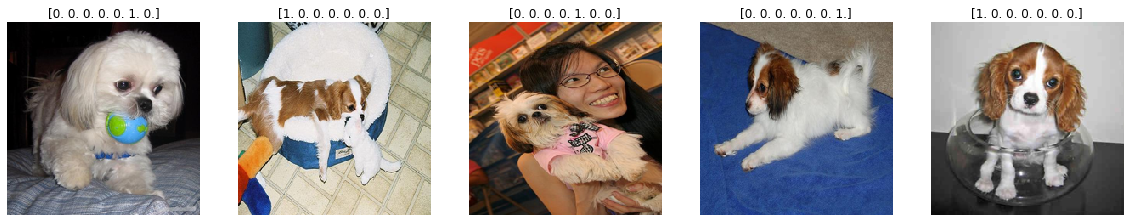

In [31]:
plt.figure(figsize = (20,20))
for i in range(5):
    img = x_train[i]
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(y_train[i])
plt.show()


In [32]:
aug = ImageDataGenerator(rotation_range=30, #rotations (as seen above)
                        width_shift_range=0.2,  # randomly shift images horizontally 
                        height_shift_range=0.2,# randomly shift images vertically 
                        horizontal_flip=True, # randomly flip images horizontally
                        fill_mode='reflect') #  creates a ‘reflection’ and fills the empty values in reverse order of the known values
# fit parameters from data
aug.fit(x_train, augment=True)

## 3. First CNN model

### 3.1 define layers

In [72]:
model = Sequential()
# layer 1
model.add(Conv2D(32, (3, 3), use_bias=False, input_shape=(227, 227, 3)))

model.add(Activation("relu"))


# layer 2

model.add(Conv2D(16, (3, 3), use_bias=False))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Activation("relu"))
model.add(Flatten())

# fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_breeds, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 225, 225, 32)      864       
_________________________________________________________________
activation_17 (Activation)   (None, 225, 225, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 223, 223, 16)      4608      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
activation_18 (Activation)   (None, 56, 56, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [73]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) #compile model
K.set_value(model.optimizer.learning_rate, 0.001)

In [74]:
%%time
history_0 = model.fit(aug.flow(x_train, y_train), 
          validation_data=(x_val, y_val),
          epochs=5)
#hist = model.fit(datagen.flow(x_train, y_train), epochs=25)

Epoch 1/5
31/31 [==============================] - 31s 1s/step - loss: 2.9835 - accuracy: 0.1592 - val_loss: 1.9423 - val_accuracy: 0.1776
Epoch 2/5
31/31 [==============================] - 31s 1s/step - loss: 1.9457 - accuracy: 0.1852 - val_loss: 1.9484 - val_accuracy: 0.2150
Epoch 3/5
31/31 [==============================] - 33s 1s/step - loss: 1.9296 - accuracy: 0.2133 - val_loss: 1.9368 - val_accuracy: 0.1963
Epoch 4/5
31/31 [==============================] - 31s 1s/step - loss: 1.9299 - accuracy: 0.2258 - val_loss: 1.9329 - val_accuracy: 0.2056
Epoch 5/5
31/31 [==============================] - 32s 1s/step - loss: 1.9111 - accuracy: 0.2508 - val_loss: 1.9229 - val_accuracy: 0.2243
CPU times: user 15min 12s, sys: 40.2 s, total: 15min 52s
Wall time: 2min 46s


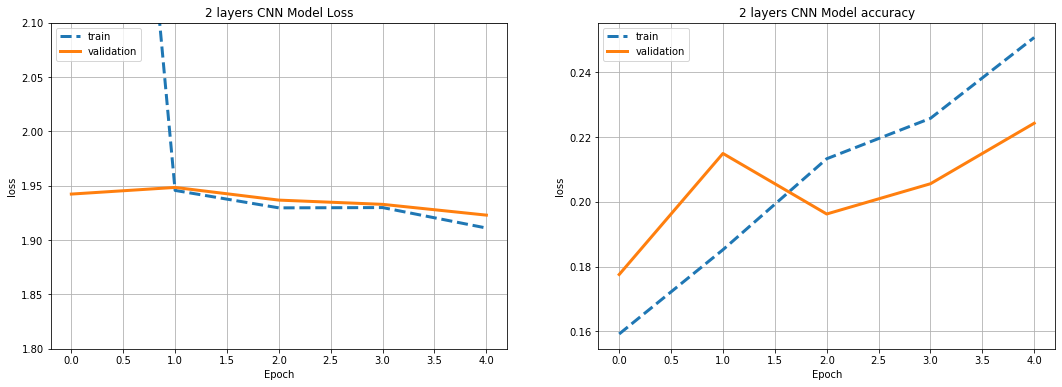

In [75]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
loss = history_0.history['loss']
val_loss = history_0.history['val_loss']
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.ylim((1.80, 2.1))
plt.xlabel('Epoch')
plt.title('2 layers CNN Model Loss')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(122)
acc = history_0.history['accuracy']
val_acc = history_0.history['val_accuracy']

plt.plot(acc,"--", linewidth=3 , label="train")
plt.plot(val_acc, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()

plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('2 layers CNN Model accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [77]:
model.evaluate(x_test, y_test)

9/9 [==============================] - 1s 145ms/step - loss: 1.8802 - accuracy: 0.2649


[1.880228042602539, 0.26492536067962646]

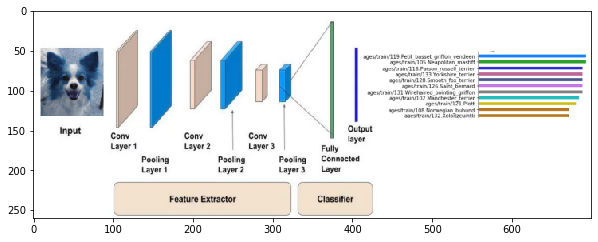

In [78]:
scheme = cv2.imread('first_model.png')
plt.figure(figsize = (10,5))
plt.imshow(scheme)

In [79]:
## inspired from http://machinememos.com/python/keras/artificial%20intelligence/machine%20learning/transfer%20learning/dog%20breed/neural%20networks/convolutional%20neural%20network/tensorflow/image%20classification/imagenet/2017/07/11/dog-breed-image-classification.html


model = Sequential()
# layer 1
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(227, 227, 3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(num_breeds, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 227, 227, 16)      432       
_________________________________________________________________
batch_normalization_4 (Batch (None, 227, 227, 16)      48        
_________________________________________________________________
activation_19 (Activation)   (None, 227, 227, 16)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 57, 57, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 57, 57, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 57, 57, 32)        4608      
_________________________________________________________________
batch_normalization_5 (Batch (None, 57, 57, 32)       

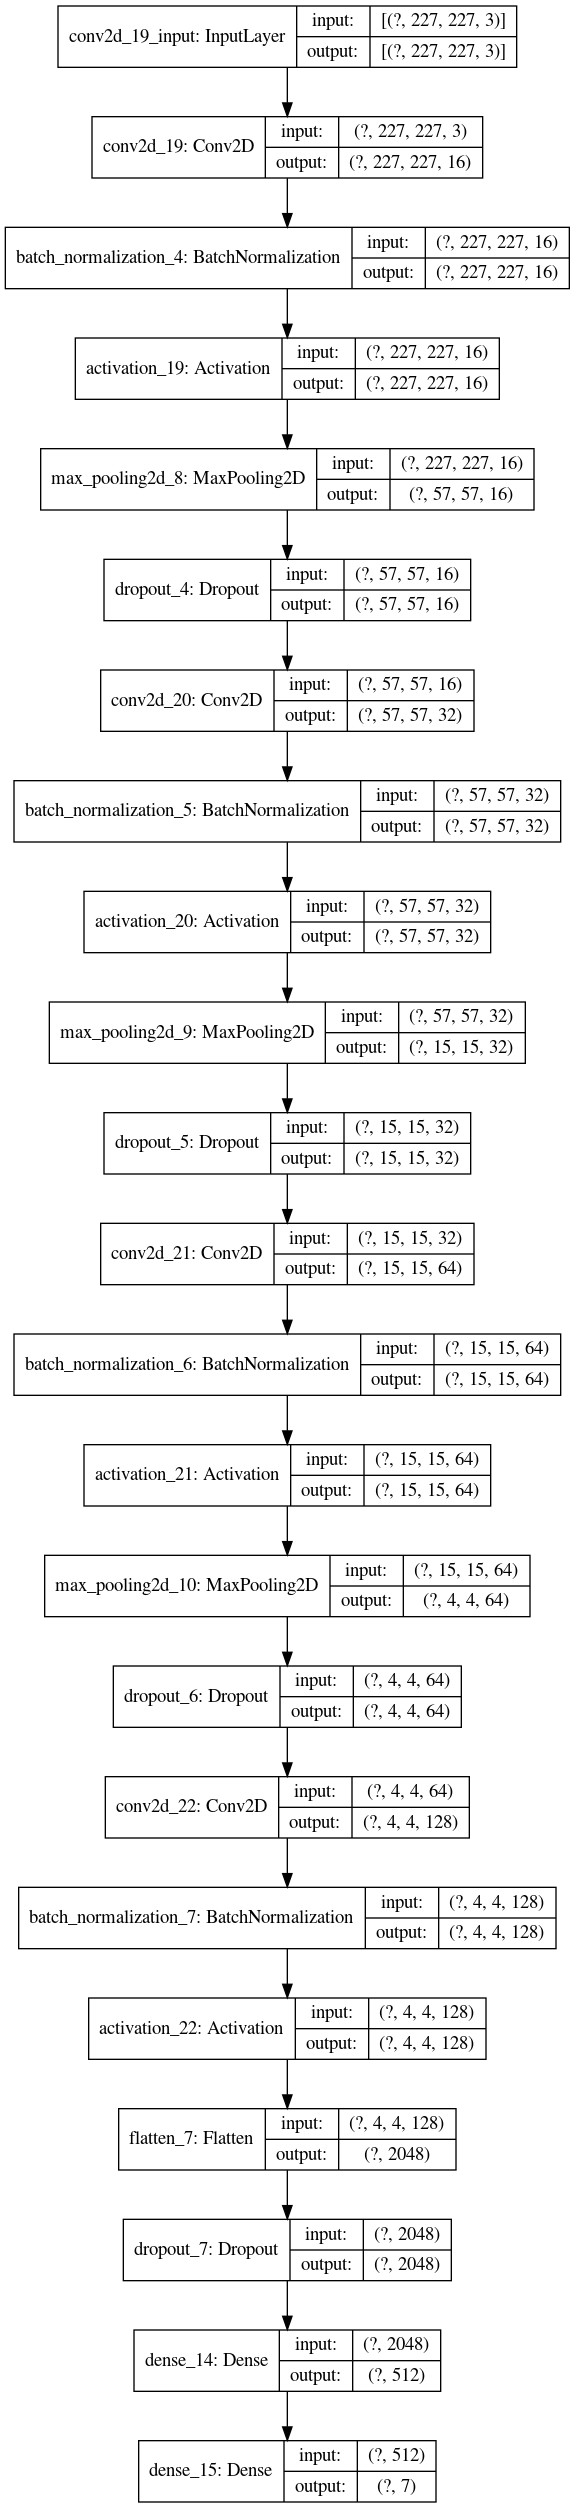

In [80]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 3.2 Compile the CNN model

In [81]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) #compile model
K.set_value(model.optimizer.learning_rate, 0.001)

### 3.3 Fit the model using training data

In [82]:
%%time
history_1 = model.fit(aug.flow(x_train, y_train), 
          validation_data=(x_val, y_val),
          epochs=30)

Epoch 1/30
31/31 [==============================] - 14s 443ms/step - loss: 2.3799 - accuracy: 0.1915 - val_loss: 1.9547 - val_accuracy: 0.1963
Epoch 2/30
31/31 [==============================] - 14s 458ms/step - loss: 1.9137 - accuracy: 0.2383 - val_loss: 2.0946 - val_accuracy: 0.1963
Epoch 3/30
31/31 [==============================] - 14s 446ms/step - loss: 1.9139 - accuracy: 0.2445 - val_loss: 2.3110 - val_accuracy: 0.1963
Epoch 4/30
31/31 [==============================] - 13s 433ms/step - loss: 1.8721 - accuracy: 0.2435 - val_loss: 2.2538 - val_accuracy: 0.1963
Epoch 5/30
31/31 [==============================] - 14s 462ms/step - loss: 1.8640 - accuracy: 0.2497 - val_loss: 2.6183 - val_accuracy: 0.1963
Epoch 6/30
31/31 [==============================] - 14s 450ms/step - loss: 1.8099 - accuracy: 0.2799 - val_loss: 2.1655 - val_accuracy: 0.2056
Epoch 7/30
31/31 [==============================] - 14s 446ms/step - loss: 1.7873 - accuracy: 0.2997 - val_loss: 2.4997 - val_accuracy: 0.1963

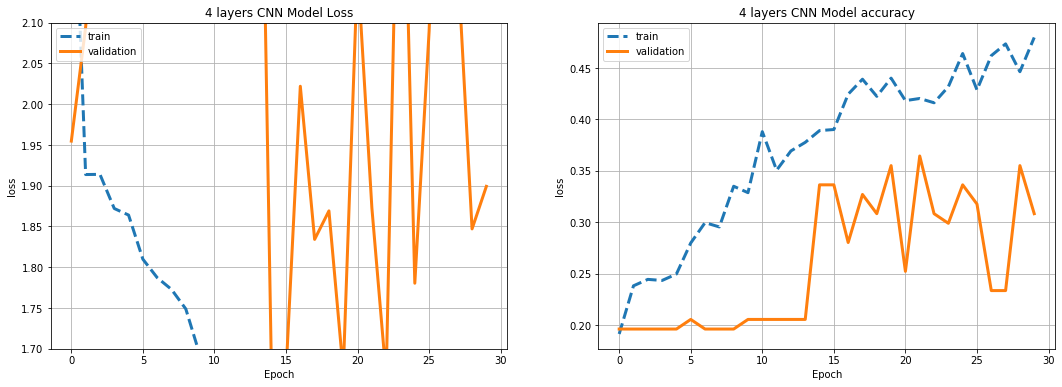

In [83]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.ylim((1.70, 2.1))
plt.xlabel('Epoch')
plt.title('4 layers CNN Model Loss')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(122)
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

plt.plot(acc,"--", linewidth=3 , label="train")
plt.plot(val_acc, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()

plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('4 layers CNN Model accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [107]:
model.evaluate(x_test, y_test)

In [108]:
print(y_train.shape)

(961, 7)


9/9 [==============================] - 1s 62ms/step - loss: 1.9731 - accuracy: 0.3507


[1.9731392860412598, 0.3507462739944458]

## 4. AlexNet

### 4.1 define layers

In [138]:
# Initializing the CNN
classifier = Sequential()

# Convolution Step 1
classifier.add(Conv2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(227, 227, 3), activation = 'relu'))

# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Conv2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Conv2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Conv2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Conv2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 1000, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = num_breeds, activation = 'softmax'))


### 4.2 compile and run

In [139]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, 0.0001)

In [140]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [144]:
%%time
history_2 = model.fit(aug.flow(x_train, y_train), 
          validation_data=(x_val, y_val),
          epochs=100)
#hist = model.fit(datagen.flow(x_train, y_train), epochs=25)

Epoch 1/100
31/31 [==============================] - 20s 646ms/step - loss: 1.2010 - accuracy: 0.5411 - val_loss: 3.4515 - val_accuracy: 0.2523
Epoch 2/100
31/31 [==============================] - 20s 643ms/step - loss: 1.1931 - accuracy: 0.5536 - val_loss: 2.5615 - val_accuracy: 0.2710
Epoch 3/100
31/31 [==============================] - 20s 643ms/step - loss: 1.1464 - accuracy: 0.5775 - val_loss: 2.8333 - val_accuracy: 0.2991
Epoch 4/100
31/31 [==============================] - 20s 639ms/step - loss: 1.1470 - accuracy: 0.5692 - val_loss: 1.4937 - val_accuracy: 0.4299
Epoch 5/100
31/31 [==============================] - 20s 631ms/step - loss: 1.1110 - accuracy: 0.6056 - val_loss: 1.8283 - val_accuracy: 0.3551
Epoch 6/100
31/31 [==============================] - 20s 631ms/step - loss: 1.1234 - accuracy: 0.6067 - val_loss: 1.4084 - val_accuracy: 0.4579
Epoch 7/100
31/31 [==============================] - 20s 648ms/step - loss: 1.1700 - accuracy: 0.5786 - val_loss: 1.7381 - val_accuracy:

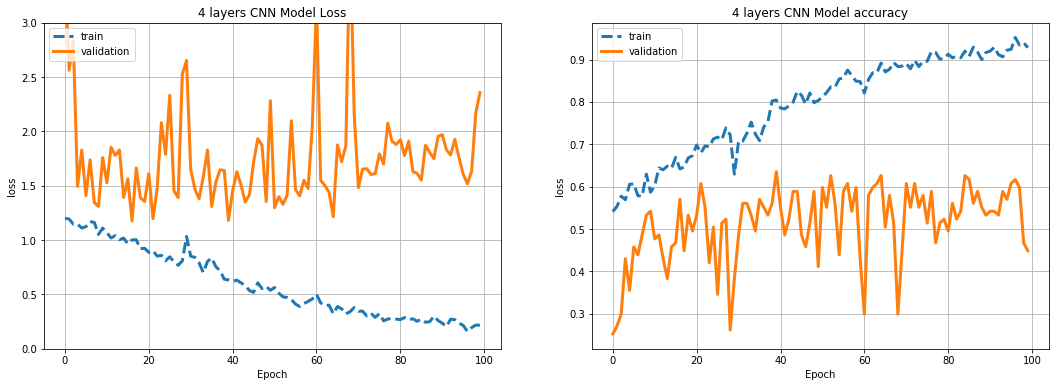

In [150]:
## plot the history of loss and accuracy for train and valid data for the Alexnet model
plt.figure(figsize=(18, 6))

plt.subplot(121)
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.ylim((0, 3))
plt.xlabel('Epoch')
plt.title('4 layers CNN Model Loss')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(122)
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

plt.plot(acc,"--", linewidth=3 , label="train")
plt.plot(val_acc, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()

plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('4 layers CNN Model accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [146]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(test_loss,test_accuracy)

9/9 [==============================] - 1s 107ms/step - loss: 1.9163 - accuracy: 0.5299
1.9163165092468262 0.5298507213592529


In [147]:
pred = model.predict(x_test)

pred.shape

(268, 7)

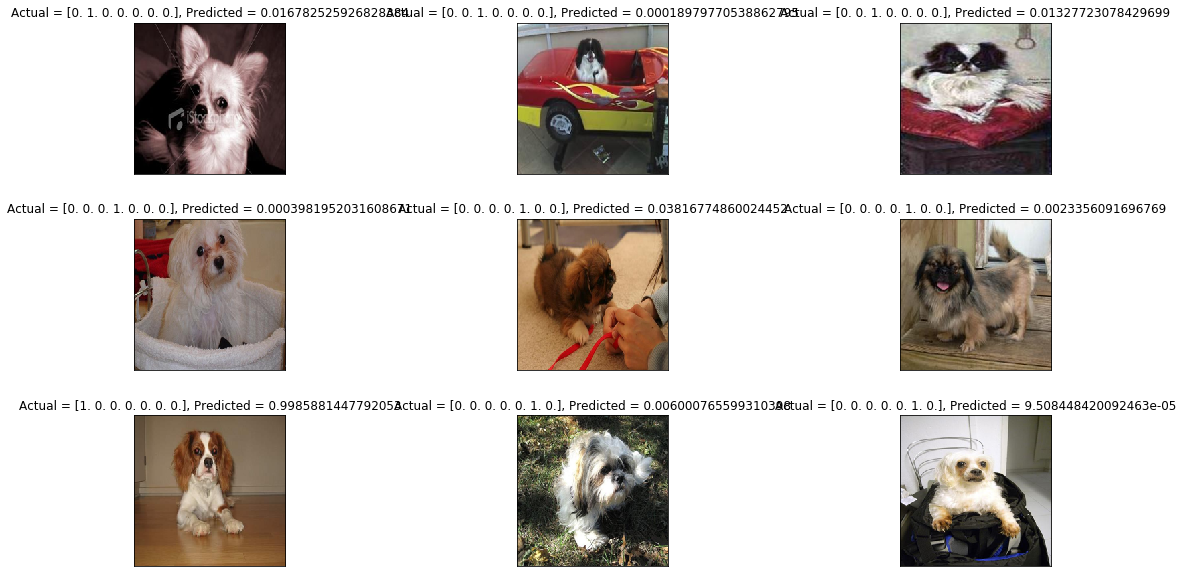

In [148]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[i])
    
    plt.title('Actual = {}, Predicted = {}'.format(y_test[i] , pred[i][0]))
    plt.xticks([]) , plt.yticks([])

plt.show()